<a href="https://colab.research.google.com/github/bobyuwono/Sign-Language-Game/blob/master/ASL_classifier_V3%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras 

from tensorflow.keras import layers
import numpy as np


In [ ]:
# ensure consistency across runs
from numpy.random import seed
seed(2)
tf.random.set_seed(2)

# Download dataset straight from Kaggle
get the kaggle API token with [this](https://www.kaggle.com/general/74235) method

then upload it in the cell below

In [ ]:
#install dependencies
!pip install kaggle

In [ ]:
#upload kaggle account credentials
from google.colab import files
files.upload()

In [ ]:
# the kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp  kaggle.json ~/.kaggle/

# this permission change avoids a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

#import dataset
!kaggle datasets download -d grassknoted/asl-alphabet

!ls

 99% 1.02G/1.03G [00:26<00:00, 50.4MB/s]
100% 1.03G/1.03G [00:26<00:00, 40.9MB/s]
asl-alphabet.zip  kaggle.json  sample_data


In [ ]:
import os
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

Samples images for letter C


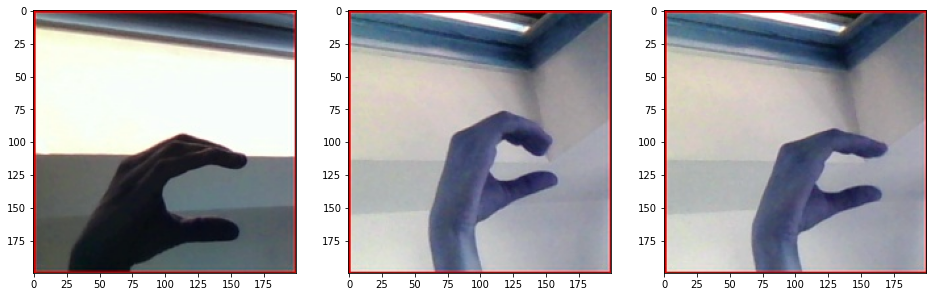

In [ ]:
# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random

def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = 'asl_alphabet_train/asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

plot_three_samples("C")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "asl_alphabet_train/asl_alphabet_train"
target_size = (60,60)
target_dims = (60,60, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 32

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [ ]:
cls_train = train_generator.classes

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [ ]:
print(cls_train)

[ 0  0  0 ... 28 28 28]


In [ ]:
#checking if each class weight is balanced
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Transfer Learning with VGG16 Model

In [ ]:
# from keras.applications.vgg16 import VGG16

pre_trained_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet', input_shape=(60,60,3))

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 60, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 30, 128)       147584    
______________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(29, activation = 'softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = Adam(lr=1e-7), 
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
tf_model = tf.keras.models.Model(pre_trained_model.input, x)

In [ ]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
2447/2447 [==============================] - 119s 49ms/step - loss: 7.6183 - accuracy: 0.0938 - val_loss: 3.5573 - val_accuracy: 0.2049
Epoch 2/30
2447/2447 [==============================] - 118s 48ms/step - loss: 5.6914 - accuracy: 0.1635 - val_loss: 2.8977 - val_accuracy: 0.3041
Epoch 3/30
2447/2447 [==============================] - 119s 49ms/step - loss: 4.3866 - accuracy: 0.2351 - val_loss: 2.4778 - val_accuracy: 0.3728
Epoch 4/30
2447/2447 [==============================] - 120s 49ms/step - loss: 3.4623 - accuracy: 0.3058 - val_loss: 2.1863 - val_accuracy: 0.4286
Epoch 5/30
2447/2447 [==============================] - 118s 48ms/step - loss: 2.8191 - accuracy: 0.3681 - val_loss: 1.9720 - val_accuracy: 0.4718
Epoch 6/30
2447/2447 [==============================] - 118s 48ms/step - loss: 2.3456 - accuracy: 0.4322 - val_loss: 1.8044 - val_accuracy: 0.5097
Epoch 7/30
2447/2447 [==============================] - 118s 48ms/step - loss: 1.9911 - accuracy: 0.4822 - val_loss: 1

# Predicting session 
belum dicoba*


In [ ]:
# upload image to be predicted
from google.colab import files
files.upload()

Saving test_c_2.jpg to test_c_2.jpg


{'test_c_2.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x07\xff\x08\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\xff\xc4\x009\x10\x01\x01\x00\x01\x04\x01\x04\x02\x02\x01\x05\x00\x00\x05\x00\x0b\x00\x01\x11\x02!1A\x03\x04\x12Qa\x05q\x06\x81\x91\x13"2\xa1\xb1#BR\xc1\xd13\x82\x92\xe1\x14br\xf0D\xa2\xf1\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00 \x11\x01\x01\x01\x01\x01\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x01\x11\x02\x03\x12\x04\x13!

In [ ]:
#helper function to predict
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(target_size, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)

    print(pred)

    # # Decode the output of the VGG16 model.
    # pred_decoded = decode_predictions(pred)[0]

    # # Print the predictions.
    # for code, name, score in pred_decoded:
    #     print("{0:>6.2%} : {1}".format(score, name))

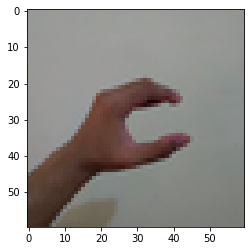

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


In [ ]:
predict(image_path='test_c_2.jpg')

In [ ]:
import os
model_version = '3'
model_name = 'asl_classifier'
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: asl_classifier/3/assets


# Save Model

In [ ]:
# zip and download files

!zip -r /content/file.zip /content/asl_classifier


  adding: content/asl_classifier/ (stored 0%)
  adding: content/asl_classifier/3/ (stored 0%)
  adding: content/asl_classifier/3/assets/ (stored 0%)
  adding: content/asl_classifier/3/saved_model.pb (deflated 90%)
  adding: content/asl_classifier/3/variables/ (stored 0%)
  adding: content/asl_classifier/3/variables/variables.index (deflated 66%)
  adding: content/asl_classifier/3/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: content/asl_classifier/3/variables/variables.data-00000-of-00002 (deflated 80%)


In [ ]:
from google.colab import files
files.download("/content/file.zip")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 42214, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil